# Data Preprocessing

In [1]:
from tqdm import tqdm
import numpy as np

with open('mxm_dataset_train_cleaned.txt', encoding='utf8') as f:
    lines = f.readlines()
    
lines = lines[17:] #The first 17th lines are some introduction

words = lines[0][1:].split(',') #The 18th line is the word vocabulary

In [2]:
# Turn word-of-bag into tf-idf
res = []
for line in tqdm(lines[1:]):
    embedding = np.zeros(50)
    count = 0
    words_ = []
    for word in line.split(',')[2:]:
        k,v = (int(x) for x in word.split(':'))
        music_ID = line.split(',')[0]
        words_+=([words[k-1]]*v)
    res.append(' '.join(words_))

100%|████████████████████████████████████████████████████████████████████████| 210519/210519 [00:45<00:00, 4666.70it/s]


In [3]:
from langdetect import detect
res1 = []
for line in tqdm(res):
    try:
        if (len(line)>150) & (detect(line)=='en'):
            res1.append(line)
    except:
        pass

100%|█████████████████████████████████████████████████████████████████████████| 210519/210519 [10:41<00:00, 328.41it/s]


In [36]:
from tqdm import tqdm
import numpy as np

with open('mxm_dataset_test.txt', encoding='utf8') as f:
    lines = f.readlines()
    
lines = lines[17:] #The first 17th lines are some introduction

words = lines[0][1:].split(',') #The 18th line is the word vocabulary

In [37]:
# Turn word-of-bag into tf-idf
res_test = []
for line in tqdm(lines[1:]):
    embedding = np.zeros(50)
    count = 0
    words_ = []
    for word in line.split(',')[2:]:
        k,v = (int(x) for x in word.split(':'))
        music_ID = line.split(',')[0]
        words_+=([words[k-1]]*v)
    res_test.append(' '.join(words_))

100%|██████████████████████████████████████████████████████████████████████████| 27143/27143 [00:06<00:00, 4447.50it/s]


In [39]:
from langdetect import detect
res1_test = []
for line in tqdm(res_test):
    try:
        if (len(line)>150) & (detect(line)=='en'):
            res1_test.append(line)
    except:
        pass

100%|███████████████████████████████████████████████████████████████████████████| 27143/27143 [01:24<00:00, 322.47it/s]


# Find the optimal number of clusters

In [71]:
import gensim.downloader as api
from itertools import combinations
glove_model = api.load("glove-wiki-gigaword-50")
def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations(term_rankings[topic_index], 2):
            try:
                pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
            except:
                pass
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [21]:
vectorizer = TfidfVectorizer(max_df=0.8, min_df=10, stop_words="english")
tf_idf_vec = vectorizer.fit_transform(res1)
tf_idf_vec_test = vectorizer.transform(res1_test)
terms =  list(vectorizer.get_feature_names_out())
score_res = []
for n in tqdm(list(range(5,30))):
    nmf = NMF(n_components=n)
    # pipeline = make_topic_pipeline(vectorizer, nmf)
    nmf.fit(tf_idf_vec)
    H = nmf.components_ 
    term_rankings=[]
    for topic_index in range(n):
        term_rankings.append(get_descriptor(terms, H, topic_index, 10))
    nmf_score = calculate_coherence(glove_model, term_rankings)
    
    lda = LatentDirichletAllocation(n_components=n,random_state=0,n_jobs=-1)
    lda.fit(tf_idf_vec)
    H = lda.components_ 
    term_rankings=[]
    for topic_index in range(n):
        term_rankings.append(get_descriptor(terms, H, topic_index, 10))
    lda_score = calculate_coherence(glove_model, term_rankings)
    perplexity = lda.perplexity(tf_idf_vec)
    score_res.append([n, nmf_score, lda_score, perplexity])
score_df = pd.DataFrame(score_res, columns = ['num_clusters','nmf_coherence', 'lda_coherence', 'lda_perplexity'])

 28%|██████████████████████▍                                                         | 7/25 [22:41<1:06:41, 222.28s/it]D:\programing\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
 32%|█████████████████████████▌                                                      | 8/25 [26:40<1:04:25, 227.40s/it]D:\programing\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
 44%|███████████████████████████████████▋                                             | 11/25 [38:44<55:16, 236.89s/it]D:\programing\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
 60%|████████████████████████████████████████████████▌          

In [22]:
score_df = pd.DataFrame(score_res, columns = ['num_clusters','nmf_coherence', 'lda_coherence', 'lda_perplexity'])
score_df

,num_clusters,nmf_coherence,lda_coherence,lda_perplexity
0,5,0.548400,0.594196,2326.091458
1,6,0.560330,0.585111,2432.926737
2,7,0.530232,0.570736,2532.164720
3,8,0.520299,0.611368,2617.705872
4,9,0.518371,0.561187,2700.081852
5,10,0.500586,0.564699,2764.781161
6,11,0.474753,0.545693,2842.617689
7,12,0.456964,0.569501,2918.077975
8,13,0.474827,0.577244,3000.728172
9,14,0.484242,0.557617,3045.081623


Text(0, 0.5, 'TC-W2V')

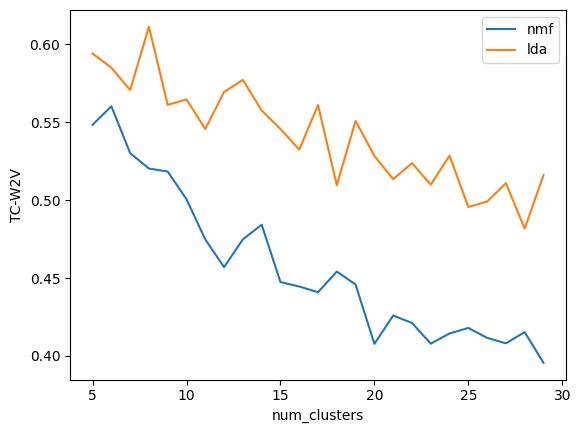

In [86]:
import matplotlib.pyplot as plt
plt.plot(score_df['num_clusters'], score_df['nmf_coherence'], label = 'nmf')
plt.plot(score_df['num_clusters'], score_df['lda_coherence'], label = 'lda')
plt.legend()
plt.xlabel('num_clusters')
plt.ylabel('TC-W2V')

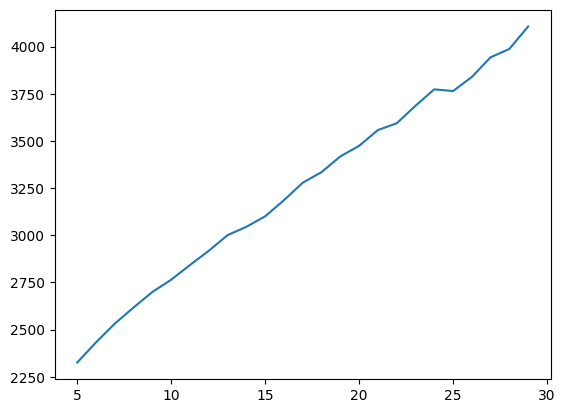

In [28]:
plt.plot(score_df['num_clusters'], score_df['lda_perplexity'], label = 'nmf')

# NMF

# Milestone 2

### By Patrick Thornton, Braedon Shick, Pu Zeng

The Code is tested under Google Colab with both CPU and T4 environments, and we strongly recommend using Colab to run our code. Please use your UM Email to open the Colab links below.

## Supervised learning

**2. CNN Genre Classification**
- We recommand using T4 for this code.

- https://colab.research.google.com/drive/1mM1gr5zNGnKEmYkOrF5Rdiw6beGFqpMM

**3. RNN Genre Classification**
- Both CPU or T4 will take a super long time to train the model. We recommand using V100/A100 to train the model.

- https://colab.research.google.com/drive/1PHJQzMdMgTzsmX-byRvSU8atASMQyLDT

**4. CNN Emotion Classificaton**
- We recommand using T4 for this notebook, as transformers are needed to generate the labels.

- https://colab.research.google.com/drive/11hK8EbE94ZXcOvYemIleYNVEHwC0VzWQ

**5. CNN Regresson with MIDI files**
- Both CPU and T4 works well for this notebook, while T4 is significantly faster.

- https://colab.research.google.com/drive/1kyOV-ov1QQsJ2df-u6rK1447iZLDzq5x

**6. CNN Regression with MP3 files**
- Both CPU and T4 works well for this notebook, while T4 is significantly faster.

- https://colab.research.google.com/drive/1Up8aXdtNe5ho945bja13-Nx2v6u7ut6m

## Unsupervised learning
GPU is not used in this notebook, so there's no need to use T4.

To see the UMAP plot of the clusters, please click on the link generated by the NMF and LDA code.

After installing the visualization library, Colab need to be restarted to work properly. We've added some code to restart the notbook after the library install. However, you need to run the "import library" cell again after the restart.

**1. TSNE on Average Glove Embeddings**
- https://colab.research.google.com/drive/1BCZr--eTRAna5L54C4b3jESrbjMdoknC

**2. LDA and NMF on Lyrics**
- https://colab.research.google.com/drive/1YbBROY315WVXjzLUXgZMTn1PehCgKCId

In [29]:
# Setting up topic modelling pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
import topicwizard
from topicwizard.pipeline import make_topic_pipeline
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

In [78]:
# Fitting pipeline
vectorizer = TfidfVectorizer(max_df=0.8, min_df=10, stop_words="english")
# NMF topic model with 20 topics
nmf = NMF(n_components=6)
pipeline = make_topic_pipeline(vectorizer, nmf)
pipeline.fit(res1)
# topicwizard.visualize(res1, pipeline=pipeline,exclude_pages=["documents"])

TopicPipeline(steps=[('tfidfvectorizer',
                      TfidfVectorizer(max_df=0.8, min_df=10,
                                      stop_words='english')),
                     ('nmf', NMF(n_components=6))])

In [79]:
# Fitting pipeline
pipeline = make_topic_pipeline(vectorizer, nmf)
pipeline.fit(res1)
topicwizard.visualize(res1, pipeline=pipeline,exclude_pages=["documents"])

Preprocessing
Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "topicwizard.app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [20/Oct/2023 17:11:08] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [20/Oct/2023 17:11:08] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [20/Oct/2023 17:11:08] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [20/Oct/2023 17:11:09] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 200 -
127.0.0.1 - - [20/Oct/2023 17:11:09] "POST /_dash-update-component HTTP/1.1" 204 -
127.0.0.1 - - [20/Oct/2023 17:11:09] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 200 -
127.0.0.1 - - [20/Oct/2023 17:11:09] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 200 -
D:\programing\anaconda3\lib\site-packages\topicwizard\prepare\topics.py:92: RuntimeWarning:

divide by zero encountered in log

D:\programing\anaconda3\lib\site-packages\topicwizard\prepare\topics.py:94: RuntimeWarning:

divide by zero encountered in log

127.0.0.1 - - [20/Oct/2023 17:11:09] "POST /_dash-update-component 

# LDA

In [92]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=8,random_state=0,n_jobs=-1)
# vectorizer = CountVectorizer(max_df=0.8, min_df=10, stop_words="english")
vectorizer = TfidfVectorizer(max_df=0.8, min_df=10, stop_words="english")
pipeline_lda = make_topic_pipeline(vectorizer, lda)
pipeline_lda.fit(res1)

TopicPipeline(steps=[('tfidfvectorizer',
                      TfidfVectorizer(max_df=0.8, min_df=10,
                                      stop_words='english')),
                     ('latentdirichletallocation',
                      LatentDirichletAllocation(n_components=8, n_jobs=-1,
                                                random_state=0))])

In [ ]:
topicwizard.visualize(res1, pipeline=pipeline_lda,exclude_pages=["documents"])

Preprocessing
Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "topicwizard.app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [20/Oct/2023 17:33:09] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [20/Oct/2023 17:33:10] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [20/Oct/2023 17:33:10] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [20/Oct/2023 17:33:10] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 200 -
127.0.0.1 - - [20/Oct/2023 17:33:10] "POST /_dash-update-component HTTP/1.1" 204 -
127.0.0.1 - - [20/Oct/2023 17:33:10] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 200 -
127.0.0.1 - - [20/Oct/2023 17:33:10] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 200 -
127.0.0.1 - - [20/Oct/2023 17:33:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Oct/2023 17:33:10] "POST /_dash-update-component HTTP/1.1" 204 -
127.0.0.1 - - [20/Oct/2023 17:33:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Oct/2023 17:33:31] "POST /_dash-update-component HTTP/1.

# Evaluation

In [25]:
lda.perplexity(vectorizer.transform(res1))

728.3351516442941

In [27]:
import math
def get_umass_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = col_i + col_j
    col_ij = (col_ij == 2).astype(int)    
    Di, Dij = col_i.sum(), col_ij.sum()    
    return math.log((Dij + 1) / Di)

def get_topic_coherence(dt_matrix, topic, n_top_words):
    indexed_topic = zip(topic, range(0, len(topic)))
    topic_top = sorted(indexed_topic, key=lambda x: 1 - x[0])[0:n_top_words]
    coherence = 0
    for j_index in range(0, len(topic_top)):
        for i_index in range(0, j_index - 1):
            i = topic_top[i_index][1]
            j = topic_top[j_index][1]
            coherence += get_umass_score(dt_matrix, i, j)
    return coherence

def get_average_topic_coherence(dt_matrix, topics, n_top_words):
    total_coherence = 0
    for i in range(0, len(topics)):
        total_coherence += get_topic_coherence(dt_matrix, topics[i], n_top_words)
    return total_coherence / len(topics)

In [28]:
avg_coherence = get_average_topic_coherence(vectorizer.transform(res1), lda.components_, 10)

In [29]:
avg_coherence

-72.91902301423343

In [30]:
avg_coherence = get_average_topic_coherence(vectorizer.transform(res1), nmf.components_, 10)

In [31]:
avg_coherence

-70.43615499524506

# Sensitivity

In [53]:
np.linspace(0.05, 0.3, 6)

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ])

[[0.21287496748707432, 2617.7058723474015],
 [0.21287496748707432, 2617.7058723474015],
 [0.21287496748707432, 2617.7058723474015],
 [0.21287496748707432, 2617.7058723474015]]

In [73]:
vectorizer = TfidfVectorizer(max_df=0.8, min_df=10, stop_words="english")
tf_idf_vec = vectorizer.fit_transform(res1)
# tf_idf_vec_test = vectorizer.fit_transform(res1_test)
terms =  list(vectorizer.get_feature_names_out())
score_res = []
for i in tqdm(np.linspace(0.05, 0.2, 6)):
    for j in np.linspace(0.05, 0.3, 6):    
        lda = LatentDirichletAllocation(n_components=8,random_state=0,n_jobs=-1,doc_topic_prior=i,topic_word_prior=j)
        lda.fit(tf_idf_vec)
        H = lda.components_ 
        term_rankings=[]
        for topic_index in range(8):
            term_rankings.append(get_descriptor(terms, H, topic_index, 10))
        lda_score = calculate_coherence(glove_model, term_rankings)
        perplexity = lda.perplexity(tf_idf_vec_test)
        score_res.append([i, j, lda_score, perplexity, lda])


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [28:39<00:00, 286.63s/it]


In [75]:
sensitivity_score = pd.DataFrame([x[:-1] for x in score_res], columns = ['doc_topic_prior', 'topic_word_prior', 'coherence','perplexity'])

In [76]:
sensitivity_score.pivot_table(index='doc_topic_prior', columns = 'topic_word_prior', values = 'coherence')

topic_word_prior,0.05,0.10,0.15,0.20,0.25,0.30
doc_topic_prior,,,,,,
0.05,0.614032,0.612816,0.613805,0.613805,0.613805,0.613805
0.08,0.619294,0.618078,0.618078,0.613958,0.619448,0.612547
0.11,0.613024,0.613116,0.613270,0.592325,0.587604,0.587604
0.14,0.607966,0.608955,0.608174,0.609242,0.604304,0.602364
0.17,0.605106,0.605106,0.597409,0.596370,0.596496,0.597592
0.20,0.591605,0.592476,0.590624,0.590067,0.591957,0.591957


In [77]:
sensitivity_score.pivot_table(index='doc_topic_prior', columns = 'topic_word_prior', values = 'perplexity')

topic_word_prior,0.05,0.10,0.15,0.20,0.25,0.30
doc_topic_prior,,,,,,
0.05,77944.442772,63438.360544,55316.775947,50486.717441,47579.443662,44890.047694
0.08,70695.939874,59101.417518,53678.683834,49597.018914,47377.456240,44970.905960
0.11,65751.774993,56283.910562,52195.922469,48921.997905,46451.041699,44496.196592
0.14,63253.270370,54461.032206,51227.271621,48527.591142,46280.654185,44450.893117
0.17,60248.733315,53100.088819,49820.009074,47785.375520,46048.885195,44503.300653
0.20,56826.679069,51793.921076,48174.138625,46761.251817,45333.855115,44130.322975
